## Medical Image Segmentation
### Winter in Data Science by Analytics Club, IIT Bombay
#### Topic: Brain Tumor Segmentation from multi-modal MRI images using U-Net architecture
#### Author: Shantanu Welling

### Dataset

LGG Segmentation Dataset: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation <br>
This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

#### References:
https://www.kaggle.com/code/victortrigo/u-net-brian-mri-segmentation/notebook <br>
AI for Medical Diagnosis Coursera

### Importing relevant libraries

In [1]:
import os 
from glob import glob
from tqdm import tqdm

import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model
tf.config.set_visible_devices([], 'GPU')

### Defining functions to load Brain scans and segment masks along with function to view the images

In [2]:
root = 'input/lgg-mri-segmentation/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [3]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|█████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:03<00:00, 993.54it/s]


### Visualizing the Data

In [4]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

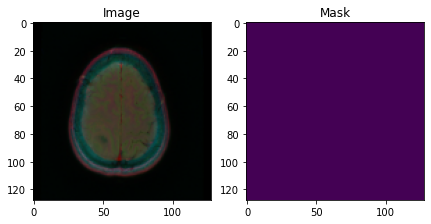

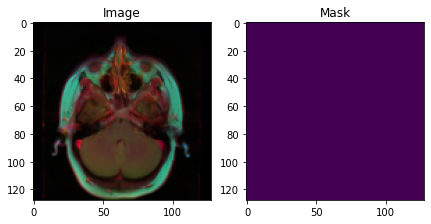

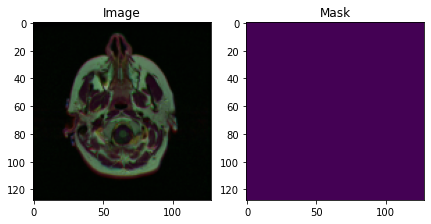

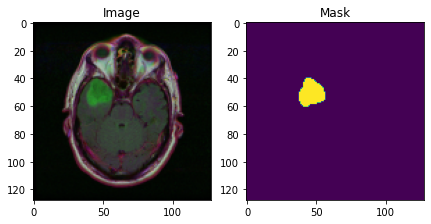

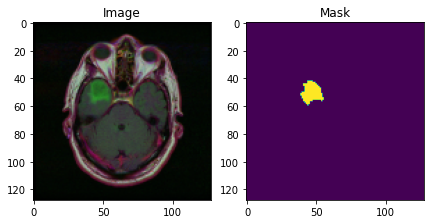

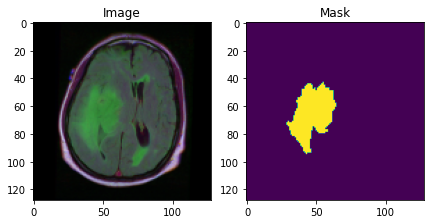

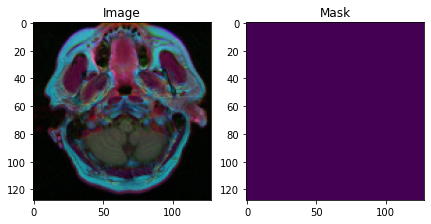

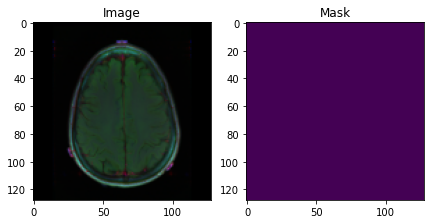

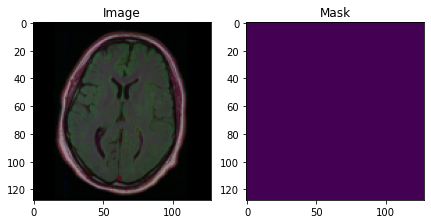

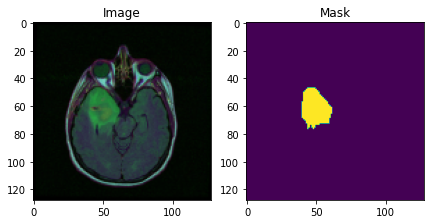

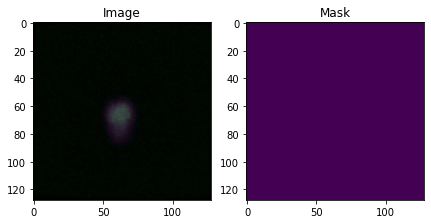

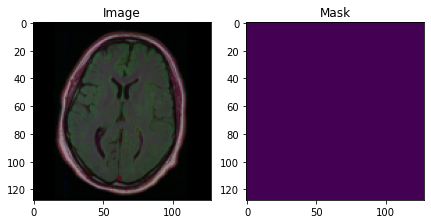

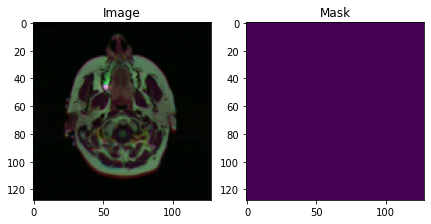

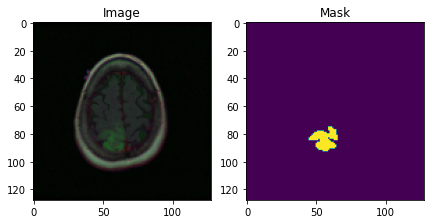

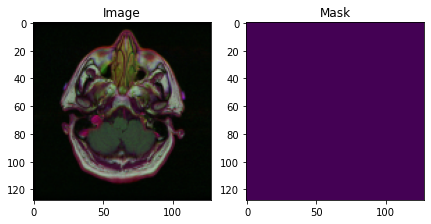

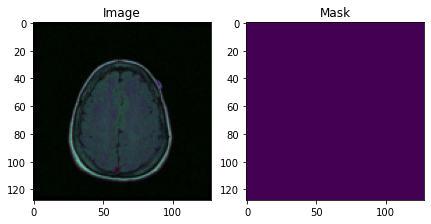

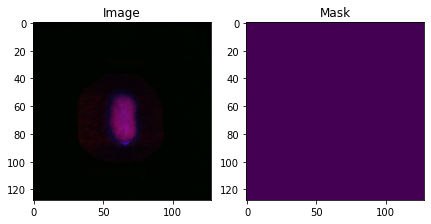

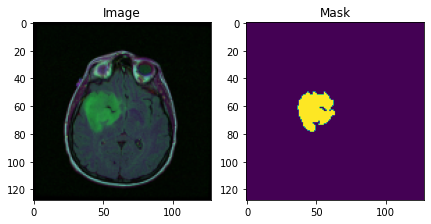

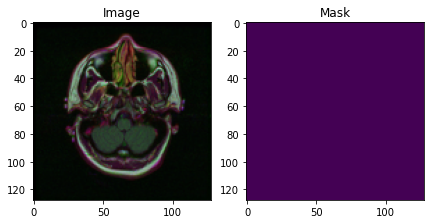

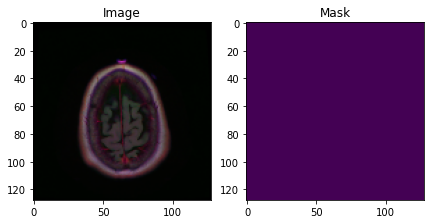

In [5]:
l = [random.randint(0,1000) for _ in range(20)]

for i in l:
    plot_image(images[i], masks[i])

In [6]:
numneg=0
numpos=0
instance=[]
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        numneg+=1
        instance.append("neg")
    else:
        numpos+=1
        instance.append("pos")

In [7]:
print('Number of positive cases ', numpos)
print('Number of negative cases: ', numneg)

Number of positive cases  1373
Number of negative cases:  2556


In [8]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])
        
images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Image dimensions ',images_pos.shape)
print('Mask dimensions ',masks_pos.shape)


Image dimensions  (1373, 128, 128, 3)
Mask dimensions  (1373, 128, 128, 1)


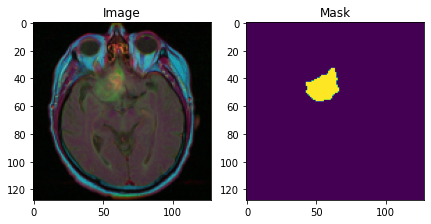

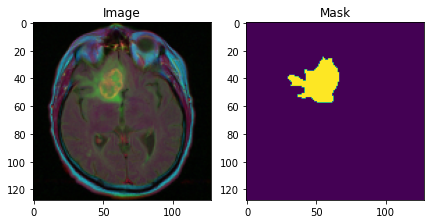

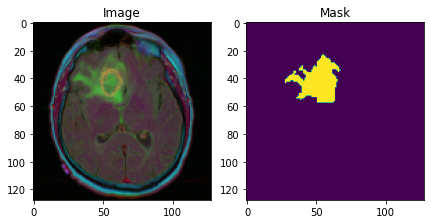

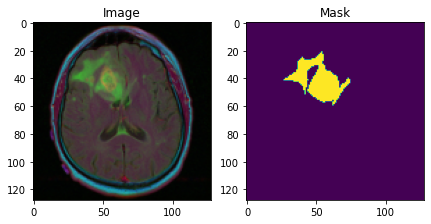

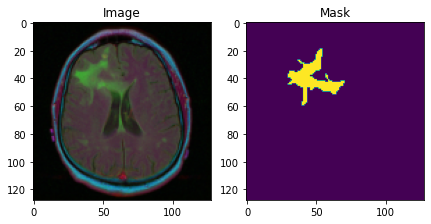

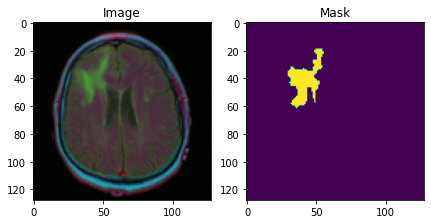

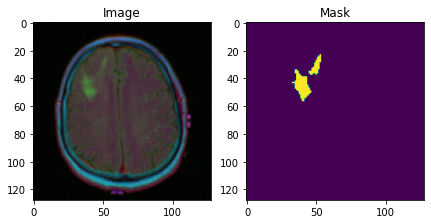

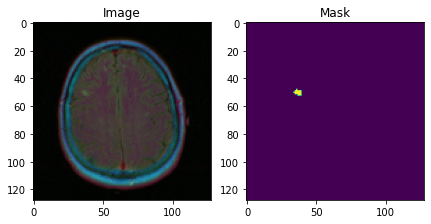

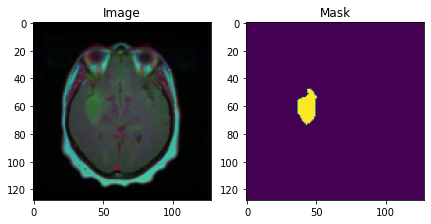

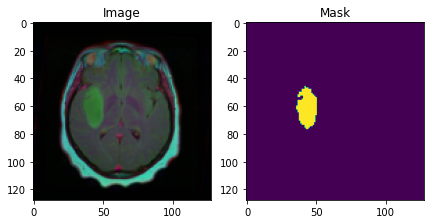

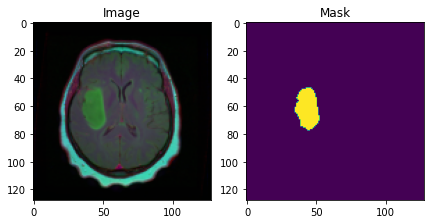

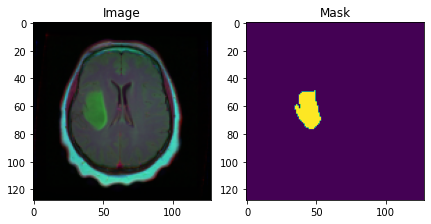

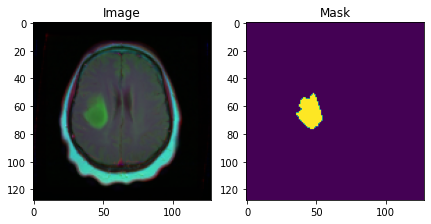

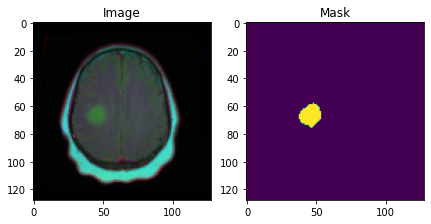

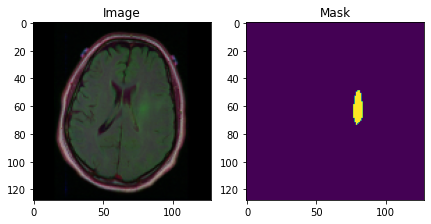

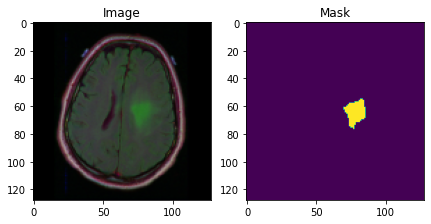

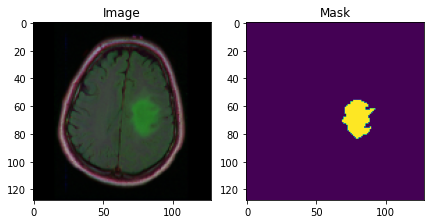

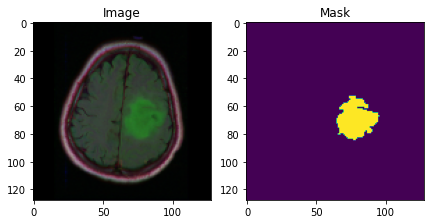

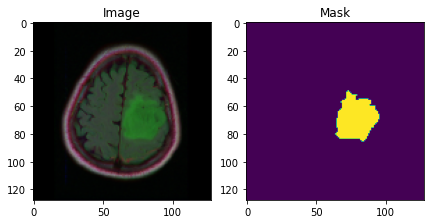

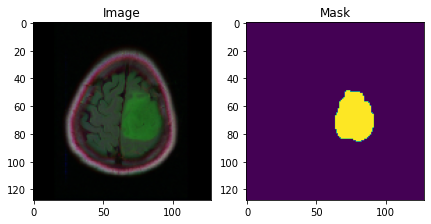

In [9]:
for i in range(20):
    plot_image(images_pos[i],masks_pos[i])

### Splitting the data into Train, Validation & Test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .25, random_state = 288)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [12]:
print('Number of train cases: ',  X_train.shape[0])
print('Number of validation cases:   ',  X_val.shape[0])
print('Number of test cases:  ',  X_test.shape[0])

Number of train cases:  1029
Number of validation cases:    172
Number of test cases:   172


### Building the U-Net Model

In [13]:
def create_conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [14]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
    # Expansion path
    
    c1 = create_conv_block(input_shape, num_filters * 1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = create_conv_block(p3, num_filters * 8)
    
    # Compression path
    
    u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    u5 = tf.keras.layers.Dropout(dropout)(u5)
    c5 = create_conv_block(u5, num_filters*4)
    
    u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters*2)
    
    u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters*1)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs = [input_shape], outputs = [output])
    
    return model 

In [15]:
inputs = tf.keras.layers.Input((128, 128, 3))
model = create_unet(inputs)

In [16]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Model Summary and Flowchart

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 dropout_3 (Dropout)            (None, 32, 32, 192)  0           ['concatenate[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   110656      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 64)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.h5',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]

#### Training the Model

In [20]:
model_history = model.fit(X_train, y_train, verbose = 1, epochs = 20, validation_data = (X_val, y_val),callbacks = my_callbacks)

Epoch 1/20
33/33 [==============================] - 92s 3s/step - loss: 0.4673 - accuracy: 0.8584 - val_loss: 11.5909 - val_accuracy: 0.2781
Epoch 2/20
33/33 [==============================] - 97s 3s/step - loss: 0.2393 - accuracy: 0.9789 - val_loss: 0.7787 - val_accuracy: 0.7322
Epoch 3/20
33/33 [==============================] - 102s 3s/step - loss: 0.1953 - accuracy: 0.9795 - val_loss: 0.3706 - val_accuracy: 0.9576
Epoch 4/20
33/33 [==============================] - 107s 3s/step - loss: 0.1607 - accuracy: 0.9815 - val_loss: 0.2534 - val_accuracy: 0.9755
Epoch 5/20
33/33 [==============================] - 113s 3s/step - loss: 0.1353 - accuracy: 0.9833 - val_loss: 0.1955 - val_accuracy: 0.9746
Epoch 6/20
33/33 [==============================] - 122s 4s/step - loss: 0.1156 - accuracy: 0.9846 - val_loss: 0.1562 - val_accuracy: 0.9791
Epoch 7/20
33/33 [==============================] - 130s 4s/step - loss: 0.0991 - accuracy: 0.9859 - val_loss: 0.1290 - val_accuracy: 0.9792
Epoch 8/20
33/

In [21]:
model.save("2D_secondrun.hdf5") #Saving the Model

### Predict and visualize testcases

In [22]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks)
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title('Ground truth mask')

In [23]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

6/6 [==============================] - 6s 563ms/step


In [24]:
for i in range(predicted_masks.shape[0]):
    for j in range(predicted_masks.shape[1]):
        for k in range(predicted_masks.shape[2]):
            if predicted_masks[i,j,k] > .5:
                predicted_masks[i,j,k] = 1
            else:
                predicted_masks[i,j,k] = 0

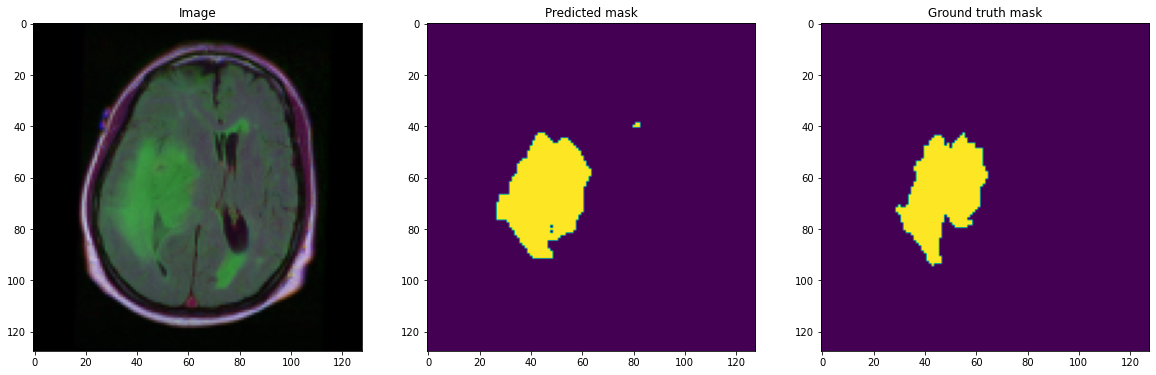

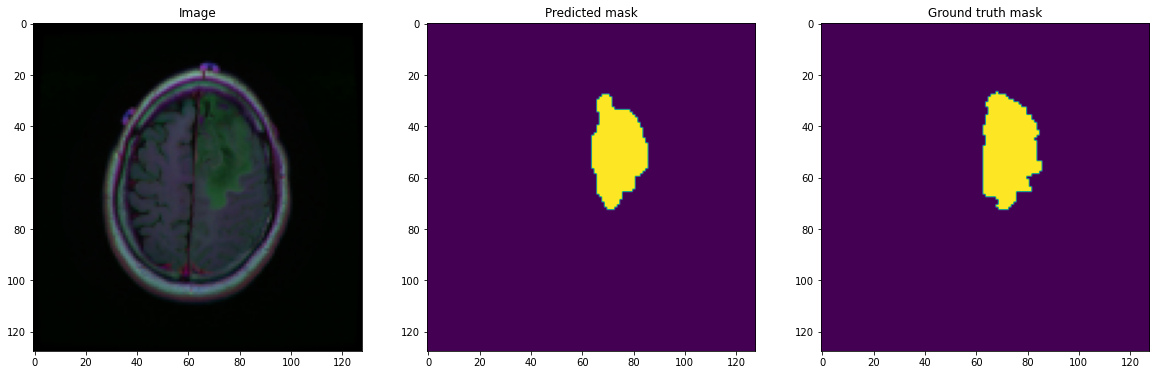

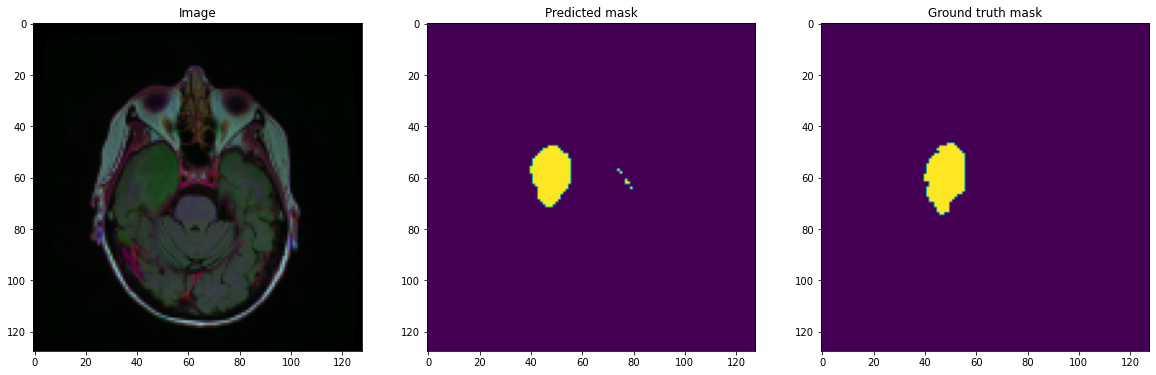

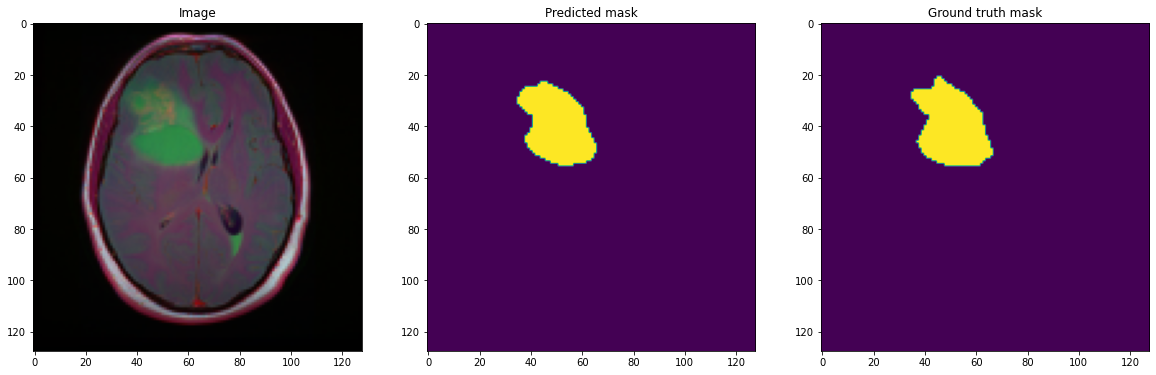

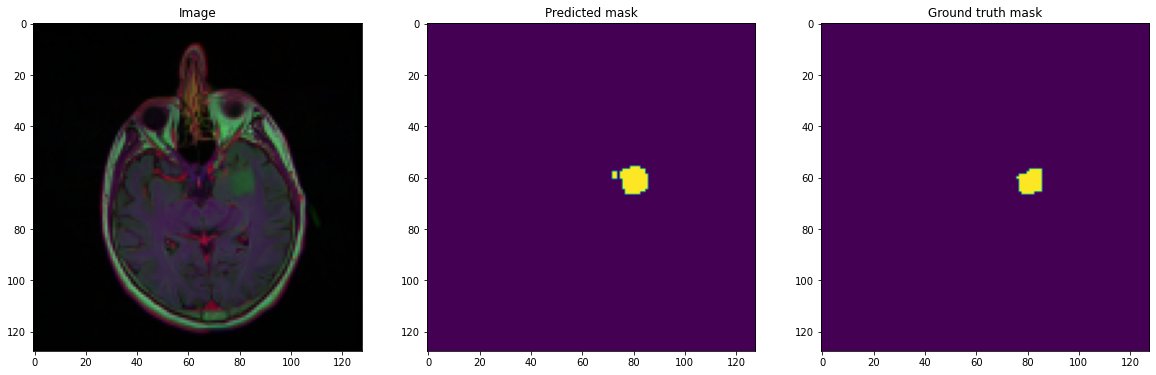

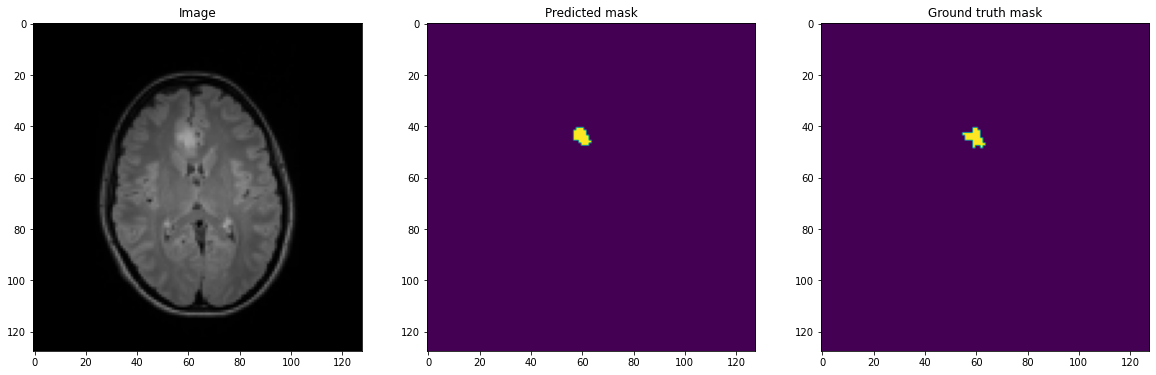

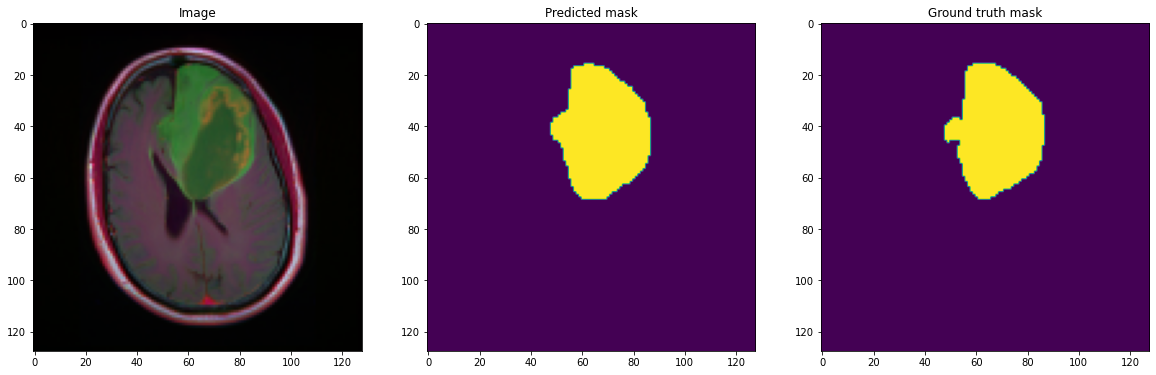

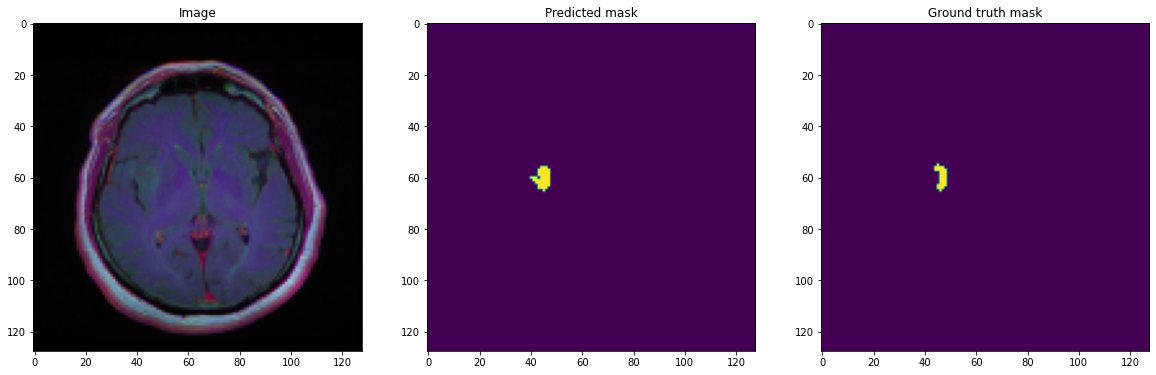

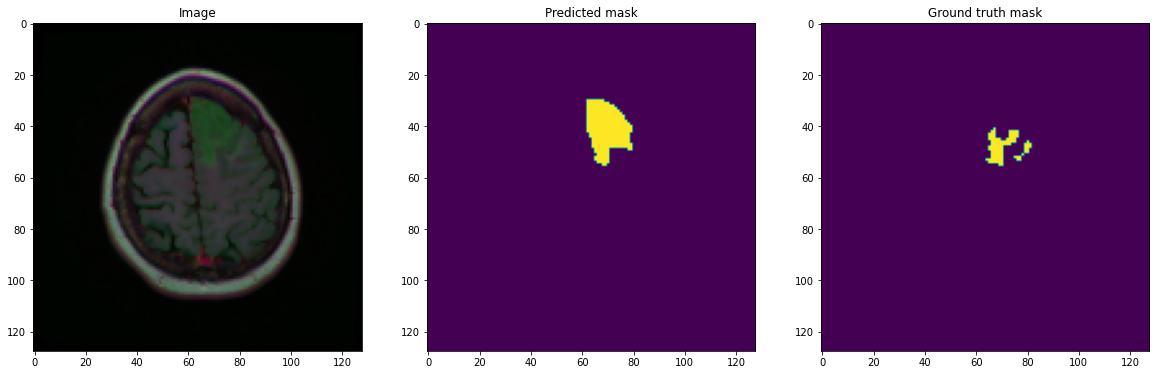

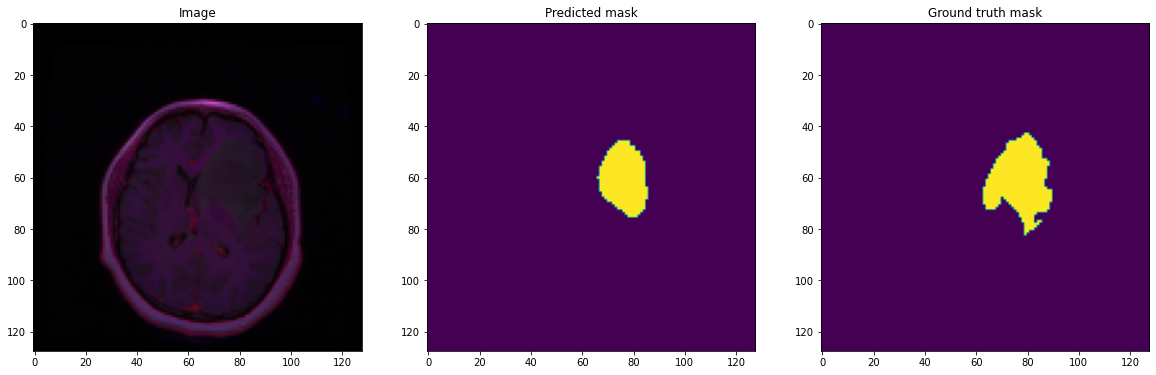

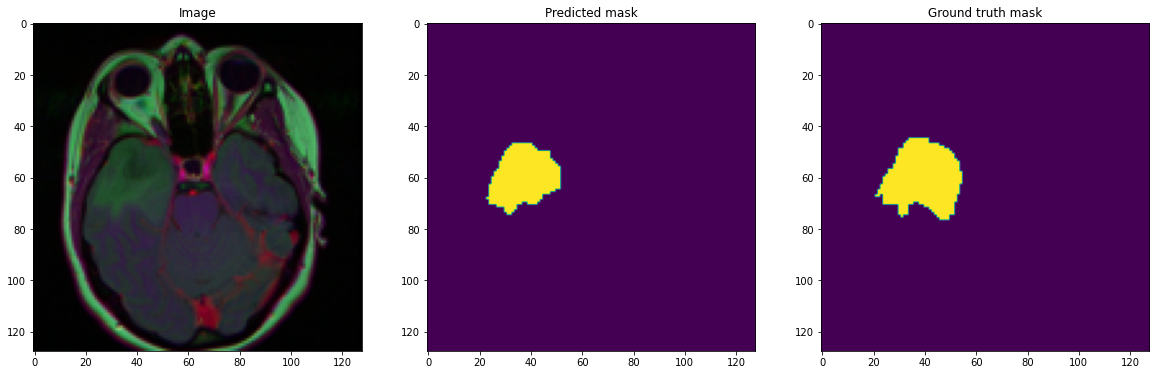

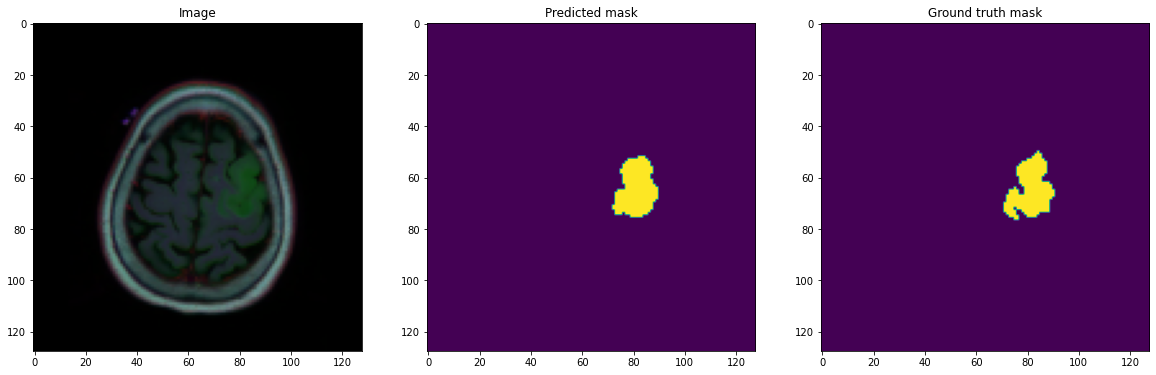

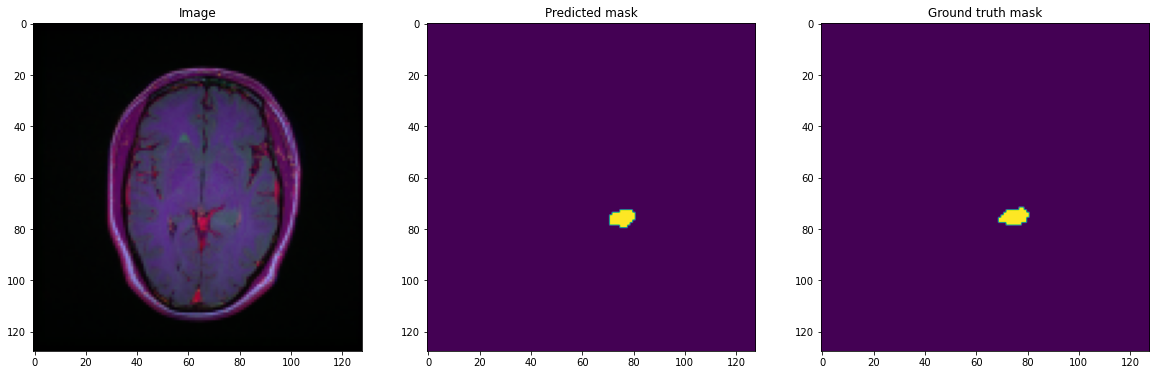

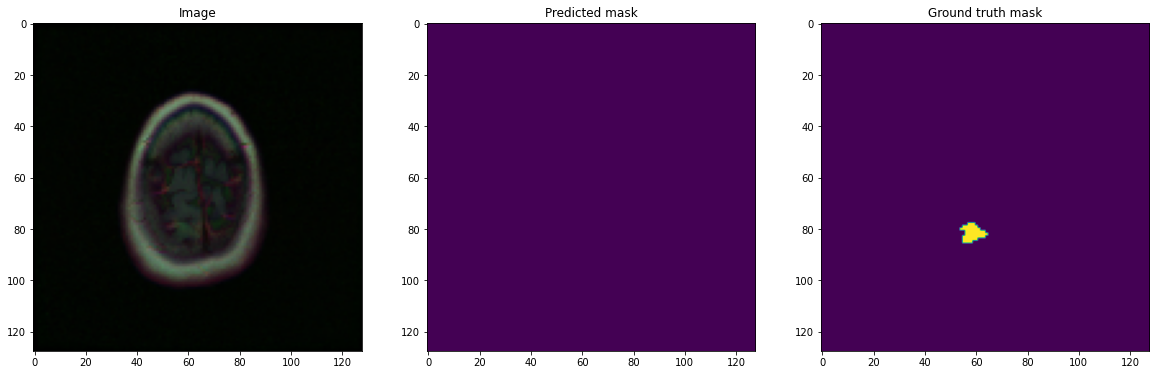

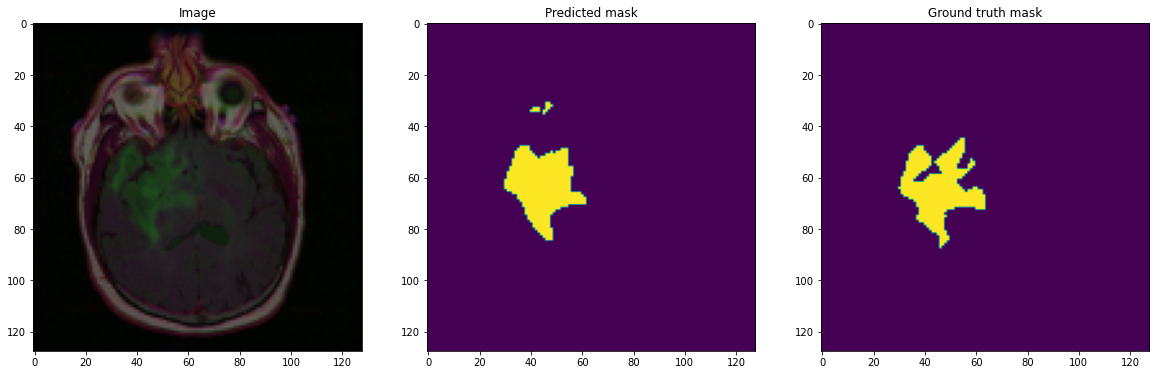

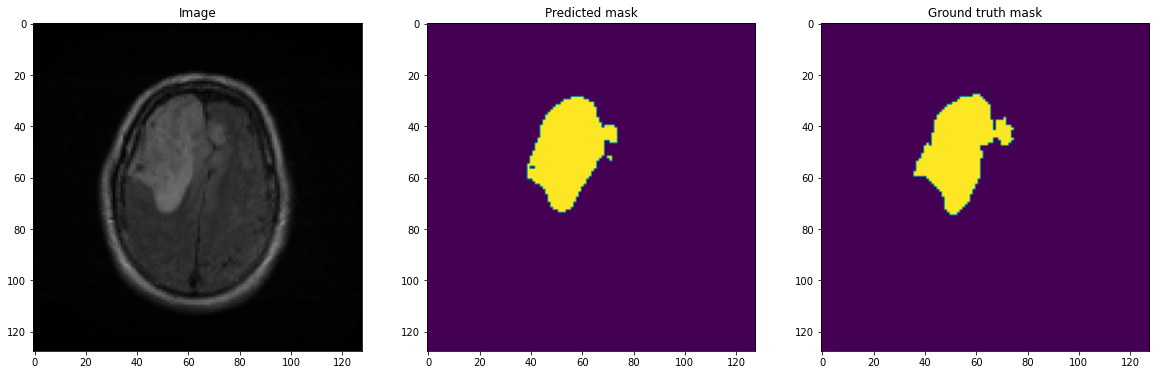

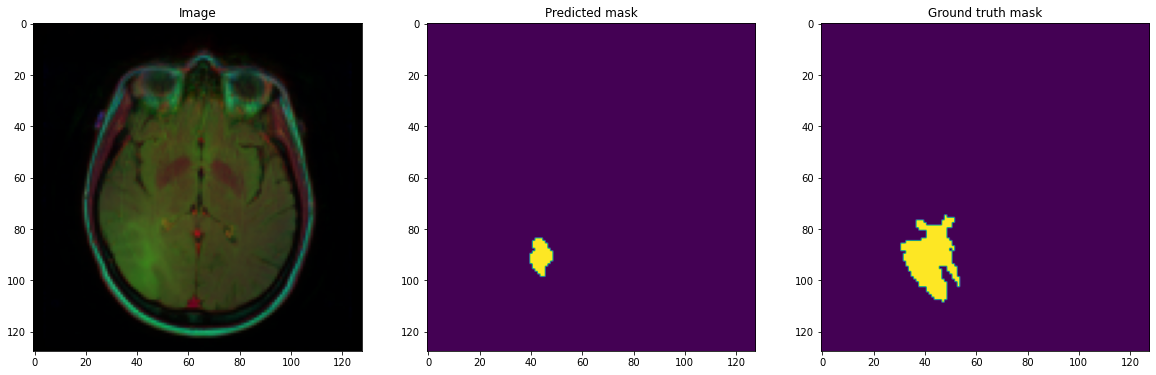

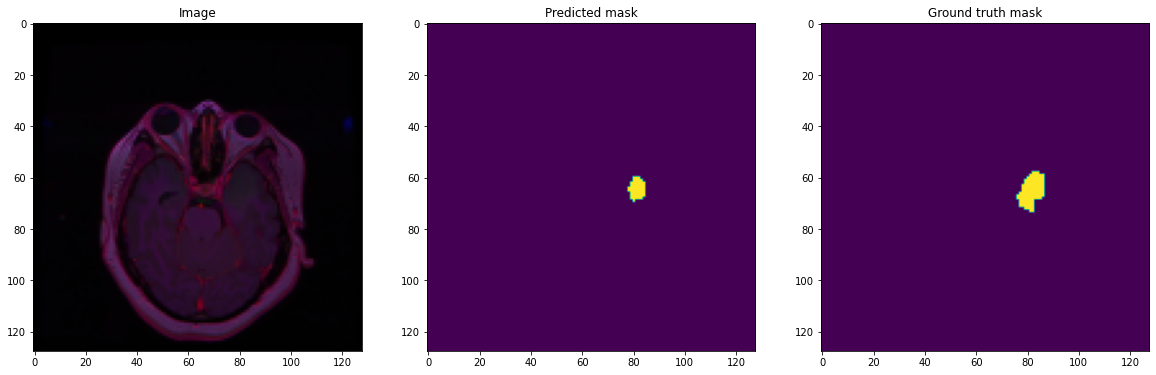

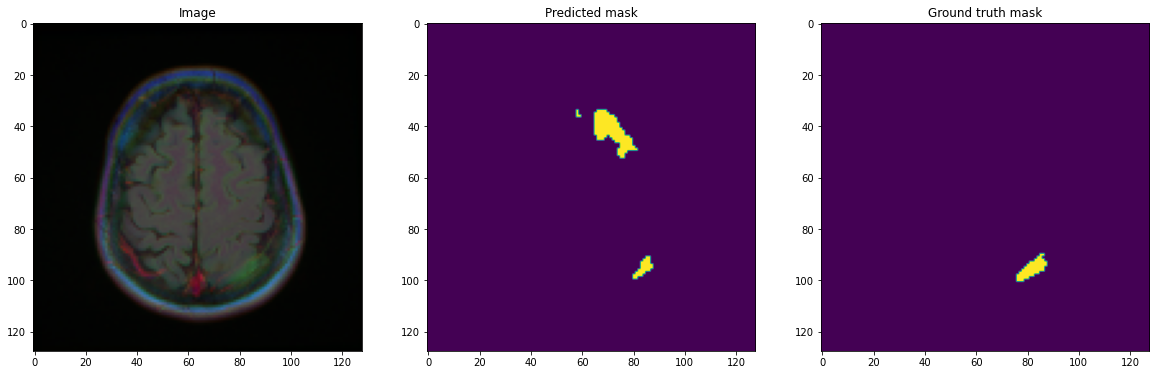

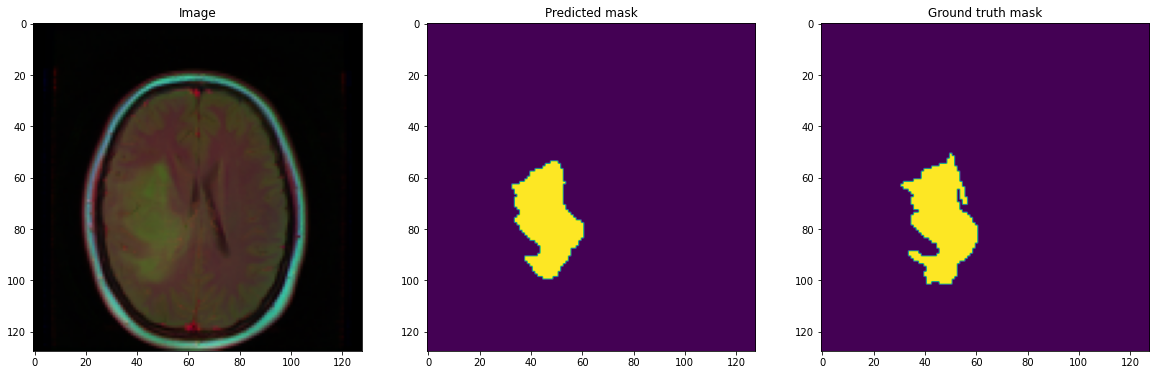

In [25]:
for idx in range(0, 20):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])

#### Compute Dice coefficient

In [26]:
def dice_coefficient(ground_truth_masks, predicted_masks, smooth=1):
    intersection = tf.reduce_sum(ground_truth_masks * predicted_masks, axis=[1, 2, 3])
    union = tf.reduce_sum(ground_truth_masks, axis=[1, 2, 3]) + tf.reduce_sum(predicted_masks, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

Dice = float(dice_coefficient(ground_truth_masks, predicted_masks, smooth=15))
print("Dice Coefficient is ", Dice)

Dice Coefficient is  0.7616410255432129


### Trying a different model with modified metrics to improve dice coefficient

#### Initializing parameters

In [78]:
imsize = [128,128,1]
batch_size = 4
n_epochs = 40
learning_rate = 1e-4
weight_decay= 1e-5

train_steps = X_train.shape[0] // batch_size
valid_steps = X_val.shape[0] // batch_size

#### Defining relevant functions & Building the new model
#### Defining loss metric functions

In [52]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation=activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

def create_unet2(image_size, widths, block_depth):
    input_image = Input(shape=imsize)
    x = layers.Conv2D(widths[0], kernel_size=1)(input_image)
    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])
    
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)
    
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])
    
    out = layers.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    
    return Model(inputs=input_image, outputs=out, name="UNet")

def combined_loss():
    def convert_to_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))
    
    def loss(y_true, y_pred, beta):
        y_pred = convert_to_logits(y_pred)
        pos_weight = beta / (1-beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred,
            labels=y_true,
            pos_weight=pos_weight,
        )
        return tf.reduce_mean(loss * (1-beta))
    
    def dice_loss(y_true, y_pred):
        numerator = 2. * tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(y_true, y_pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        return tf.reduce_mean(1 - x)
    
    def combined(y_true, y_pred,):
        return 0.5*dice_loss(y_true, y_pred) + 0.5*loss(y_true, y_pred, 0.8)
    
    return combined

class DiceScore(tf.keras.metrics.Metric):
    def __init__(self, name="DiceScore", **kwargs):
        super(DiceScore, self).__init__(name=name, **kwargs)
        self.mean_dice = metrics.Mean(name="DiceScore_Tracker")
    
    def update_state(self, real, pred, sample_weight=None):
        numerator = 2. * tf.reduce_sum(tf.multiply(real, pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(real, pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        x = tf.reduce_mean(x)
        self.mean_dice.update_state(x)
    
    def result(self):
        return self.mean_dice.result()

    def reset_state(self):
        self.mean_dice.reset_state()

#### Setting learning rate & its decay

In [79]:
initial_learning_rate = learning_rate
decay_steps =train_steps*int(0.85*n_epochs)
alpha = 1e-3


def decayed_learning_rate(step):
    step = np.minimum(step, decay_steps)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

### Building the second model based on Dice coefficient

In [80]:
lr = tf.keras.optimizers.schedules.CosineDecay(learning_rate, decay_steps=decay_steps, alpha=alpha)
inputs1 = tf.keras.layers.Input((128, 128, 3))
model2=create_unet(inputs1)
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=lr,decay=weight_decay,),loss=combined_loss(),metrics=[DiceScore()],)

In [55]:
model2.summary() #Model summary

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 128, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_56 (BatchN  (None, 128, 128, 16  64         ['conv2d_60[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 concatenate_12 (Concatenate)   (None, 32, 32, 192)  0           ['conv2d_transpose_12[0][0]',    
                                                                  'activation_61[0][0]']          
                                                                                                  
 dropout_27 (Dropout)           (None, 32, 32, 192)  0           ['concatenate_12[0][0]']         
                                                                                                  
 conv2d_68 (Conv2D)             (None, 32, 32, 64)   110656      ['dropout_27[0][0]']             
                                                                                                  
 batch_normalization_64 (BatchN  (None, 32, 32, 64)  256         ['conv2d_68[0][0]']              
 ormalization)                                                                                    
          

In [81]:
#Initializing callbacks
cbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_DiceScore", patience=np.ceil(0.05*n_epochs).astype(int),mode="max",restore_best_weights=True,),]

#### Training the second model

In [82]:
model2_history = model2.fit(X_train, 
                          y_train,
                          validation_data = (X_val, y_val),
                          steps_per_epoch = train_steps,
                          validation_steps = valid_steps,
                          epochs = n_epochs,
                          callbacks = cbacks,)

Epoch 1/40
257/257 [==============================] - 252s 976ms/step - loss: 0.4544 - DiceScore: 0.1630 - val_loss: 0.4433 - val_DiceScore: 0.1706
Epoch 2/40
257/257 [==============================] - 254s 985ms/step - loss: 0.3911 - DiceScore: 0.2606 - val_loss: 0.3783 - val_DiceScore: 0.2900
Epoch 3/40
257/257 [==============================] - 259s 1s/step - loss: 0.3515 - DiceScore: 0.3294 - val_loss: 0.3392 - val_DiceScore: 0.3530
Epoch 4/40
257/257 [==============================] - 263s 1s/step - loss: 0.3203 - DiceScore: 0.3851 - val_loss: 0.3045 - val_DiceScore: 0.4175
Epoch 5/40
257/257 [==============================] - 256s 999ms/step - loss: 0.2842 - DiceScore: 0.4528 - val_loss: 0.2782 - val_DiceScore: 0.4668
Epoch 6/40
257/257 [==============================] - 255s 992ms/step - loss: 0.2555 - DiceScore: 0.5080 - val_loss: 0.2466 - val_DiceScore: 0.5260
Epoch 7/40
257/257 [==============================] - 249s 969ms/step - loss: 0.2240 - DiceScore: 0.5692 - val_loss: 0

In [83]:
model2.save("model2_1.hdf5") #Saving the second model

### Predicting testcases and visualizing the results

In [84]:
predicted_masks2, test_images2, ground_truth_masks2 = predict_test_samples(X_test, y_test, model2)

6/6 [==============================] - 2s 313ms/step


In [87]:
for i in range(predicted_masks2.shape[0]):
    for j in range(predicted_masks2.shape[1]):
        for k in range(predicted_masks2.shape[2]):
            if predicted_masks2[i,j,k] > .5:
                predicted_masks2[i,j,k] = 1
            else:
                predicted_masks2[i,j,k] = 0

In [88]:
Dice = float(dice_coefficient(ground_truth_masks2, predicted_masks2, smooth=45))
print('Dice score', Dice)

Dice score 0.8147171139717102


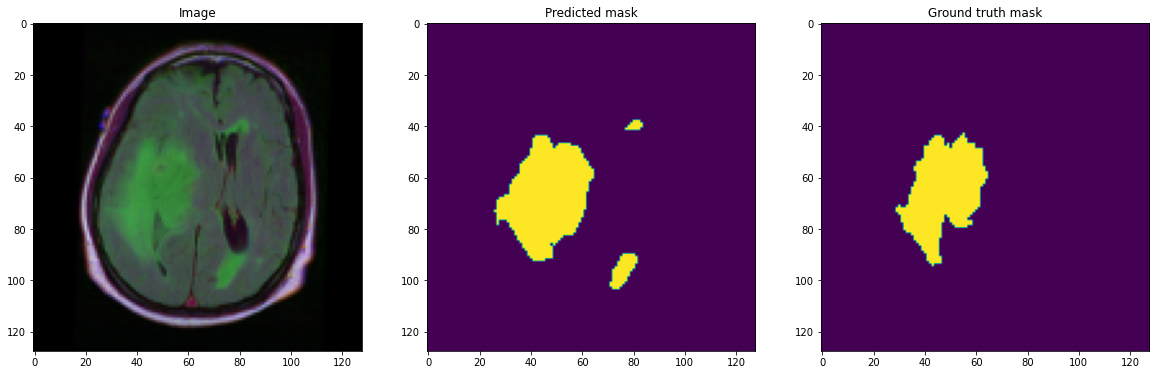

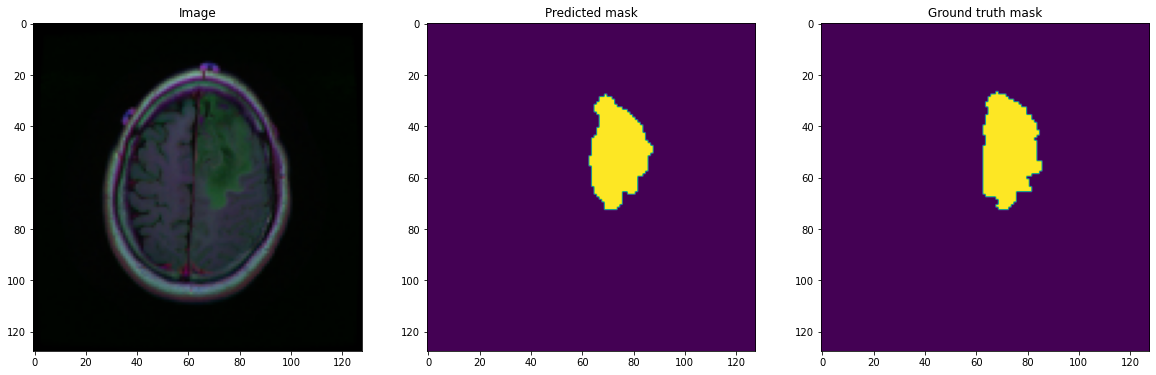

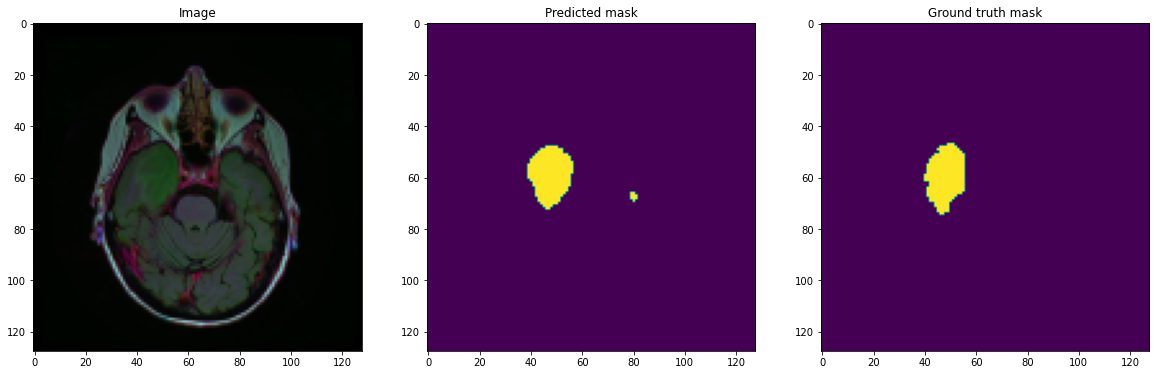

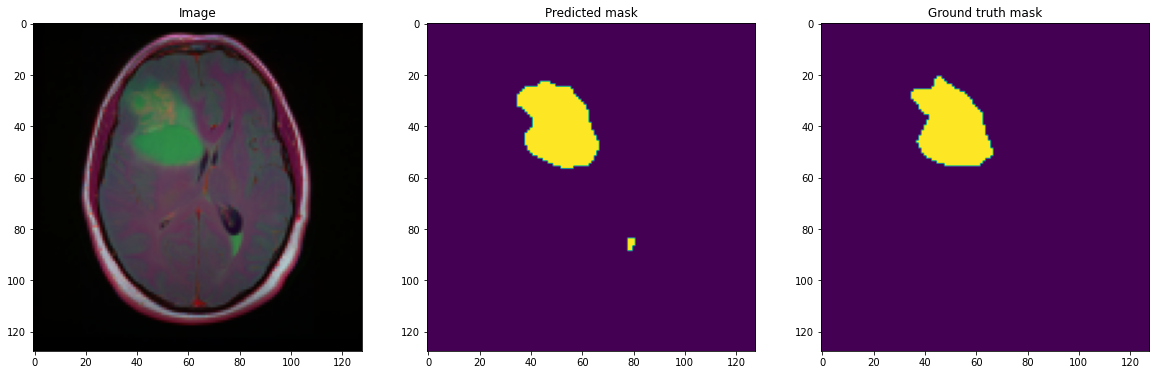

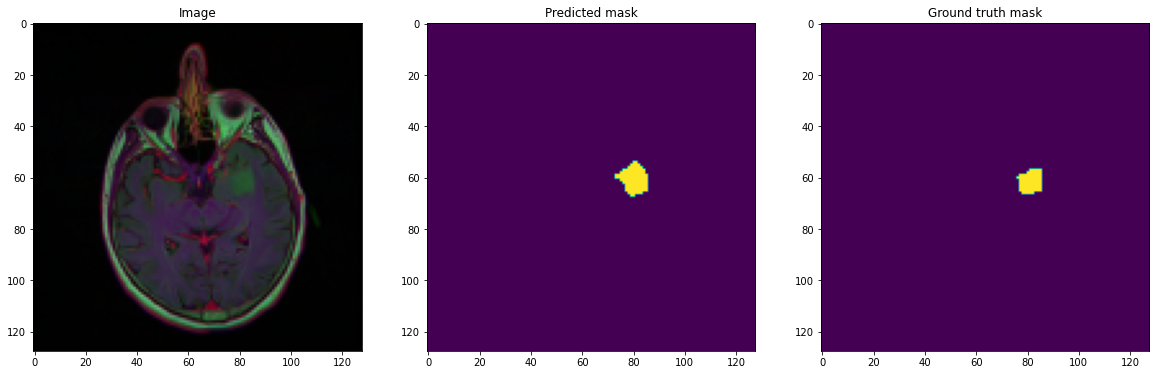

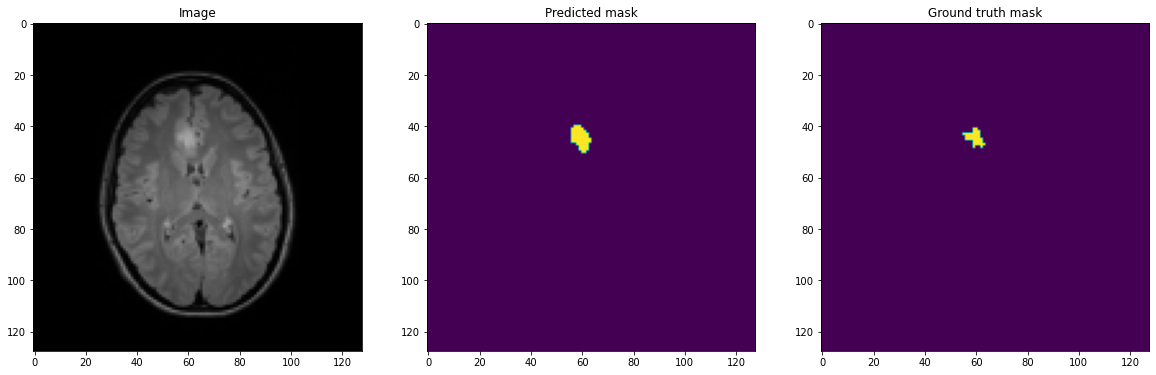

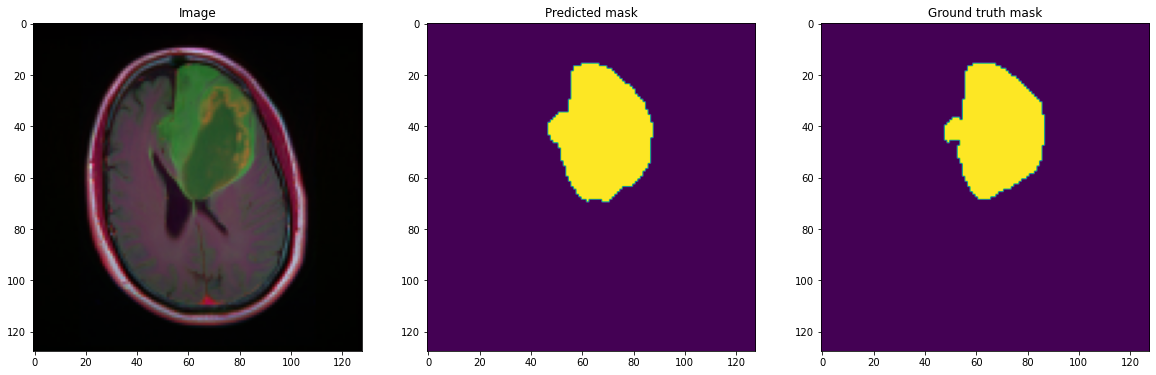

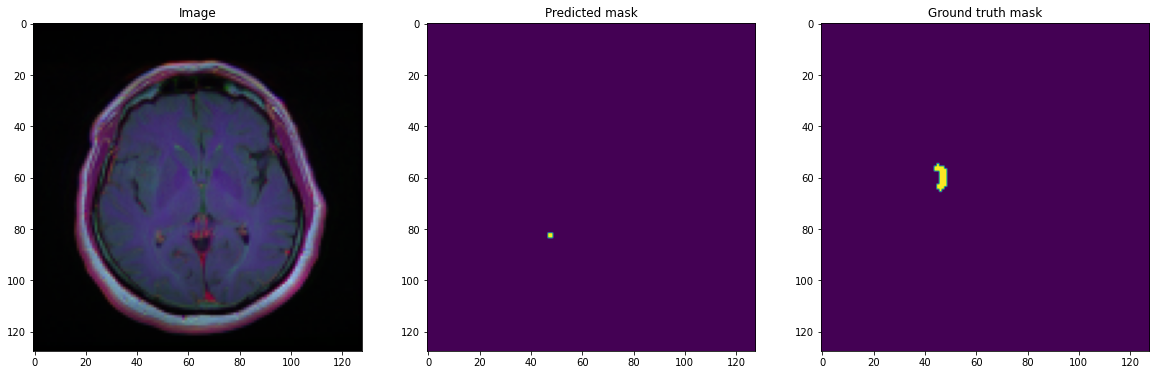

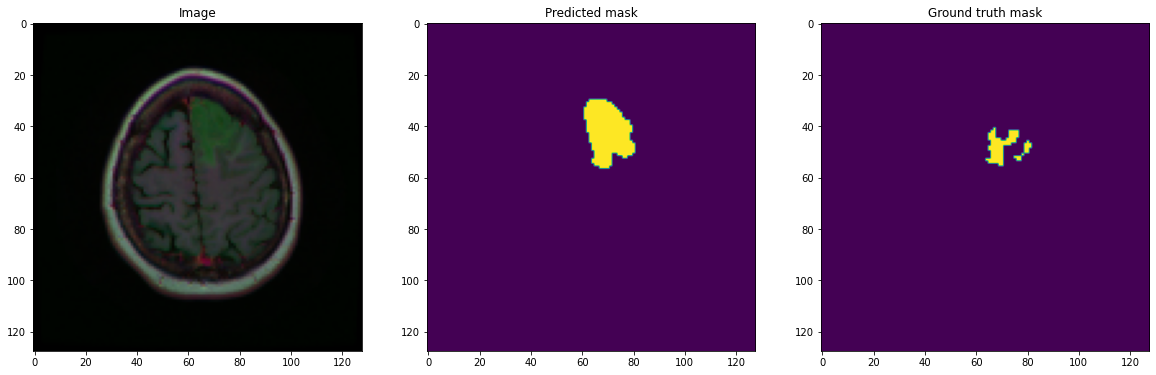

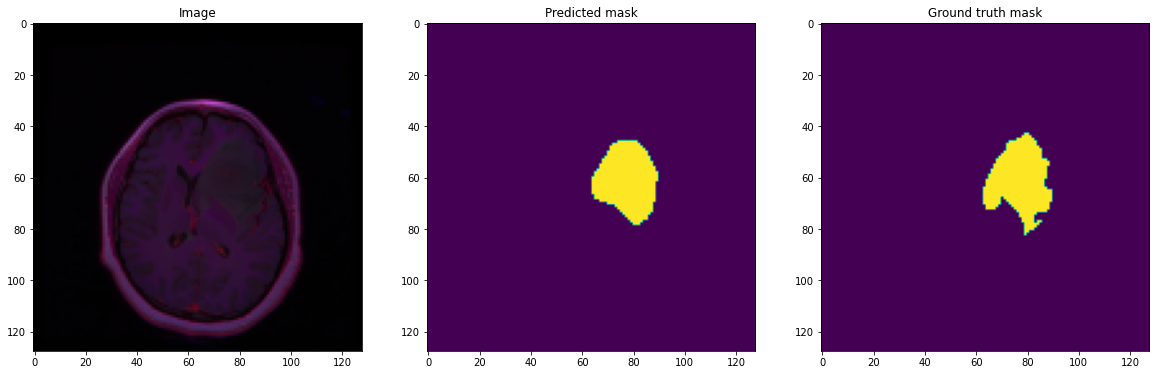

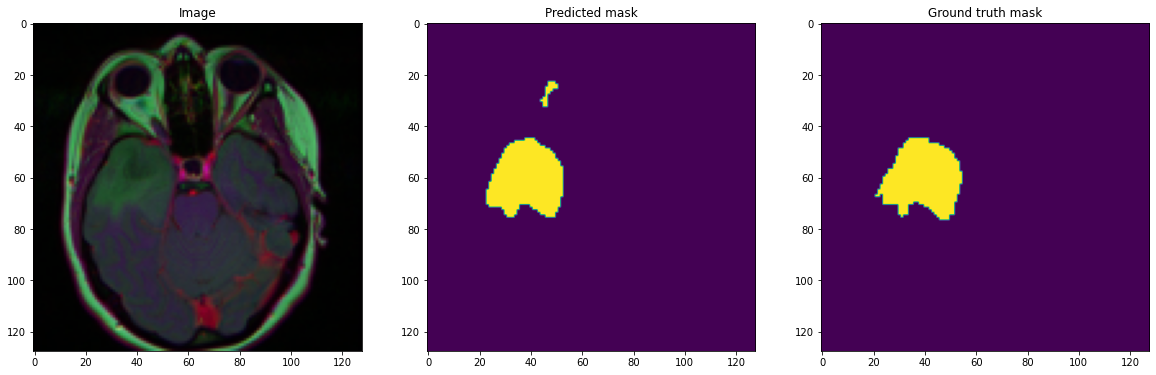

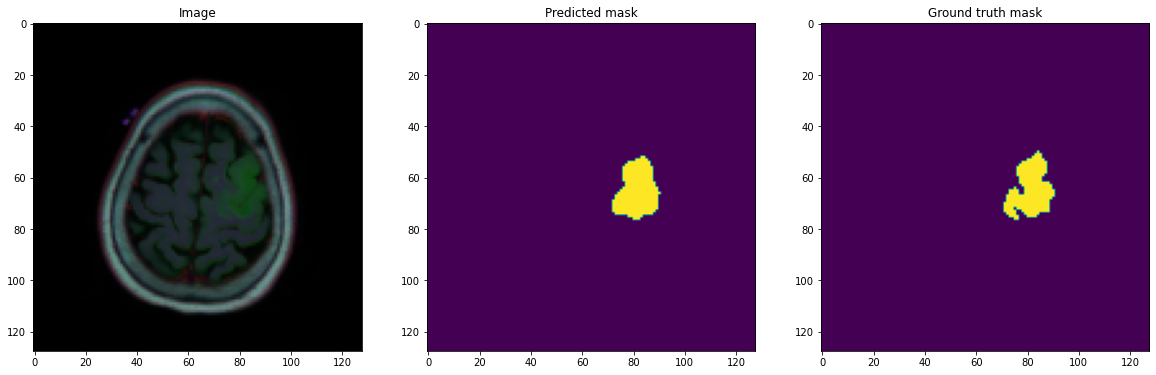

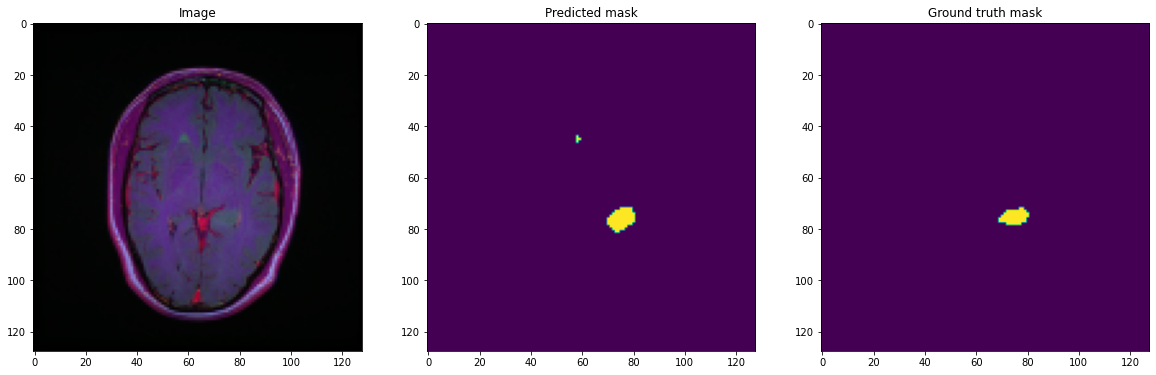

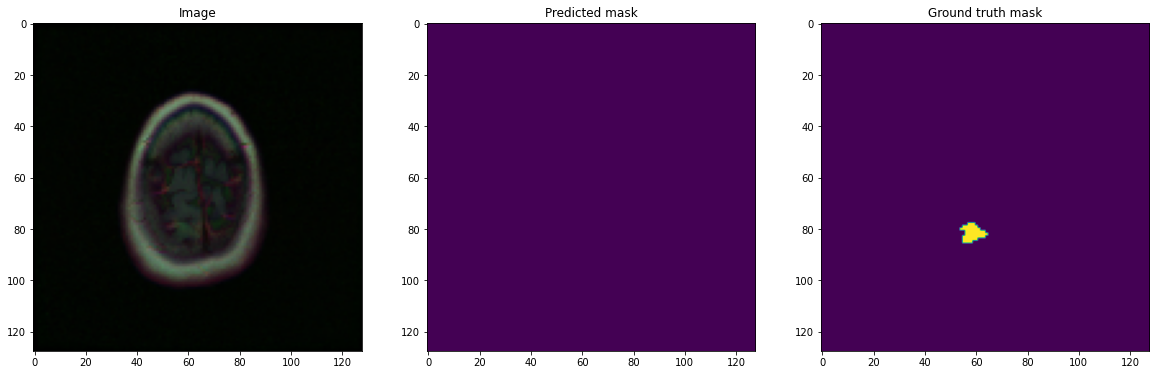

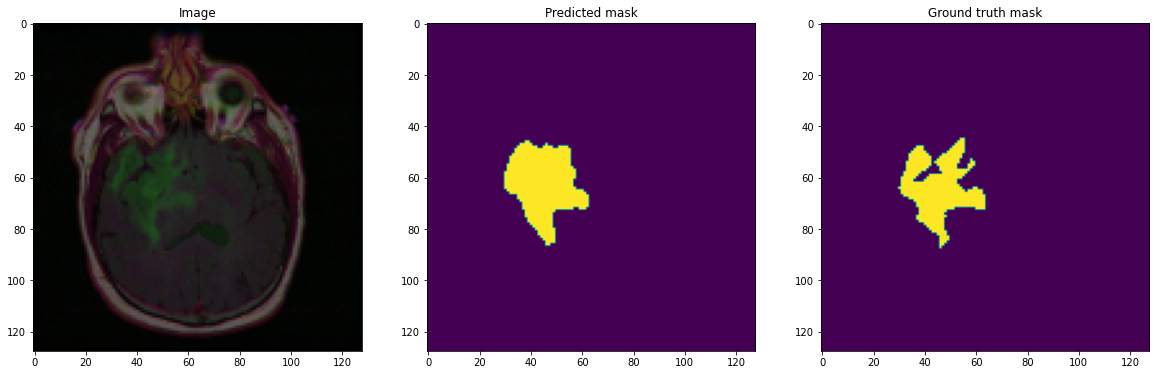

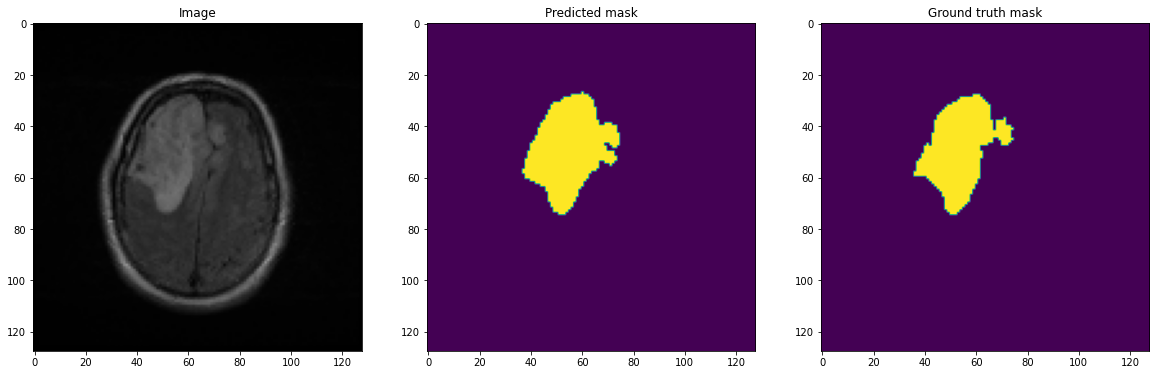

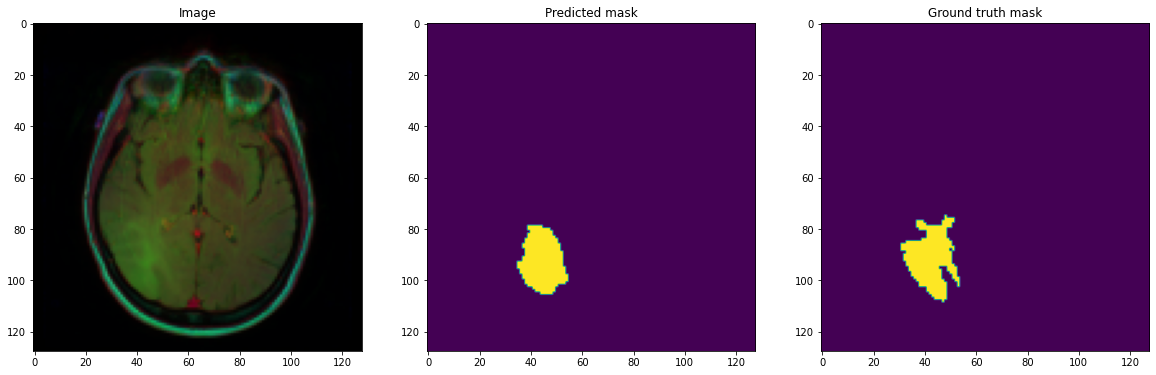

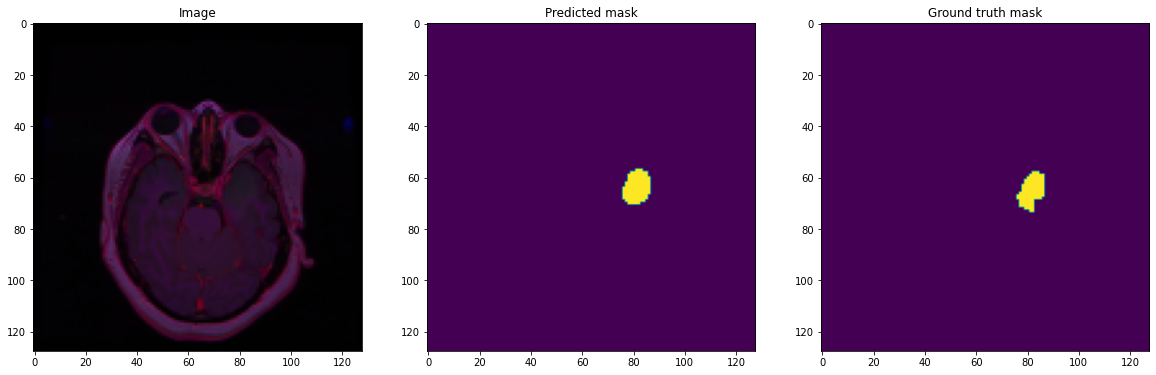

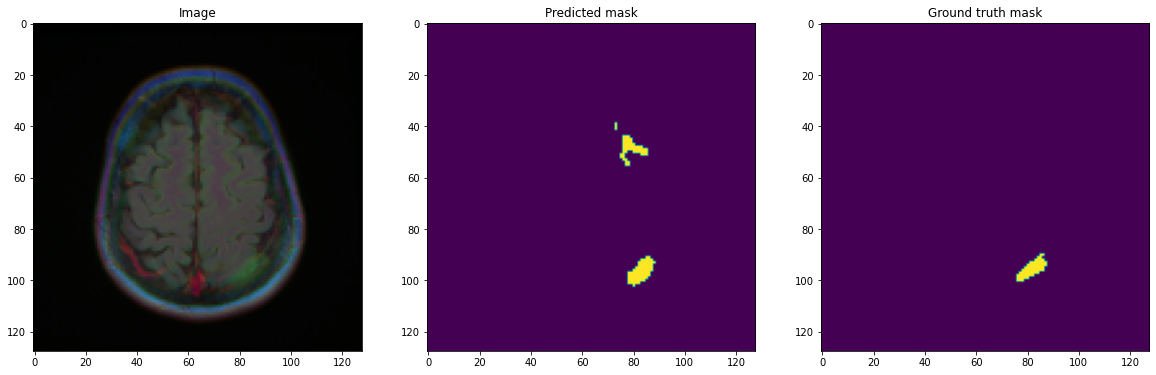

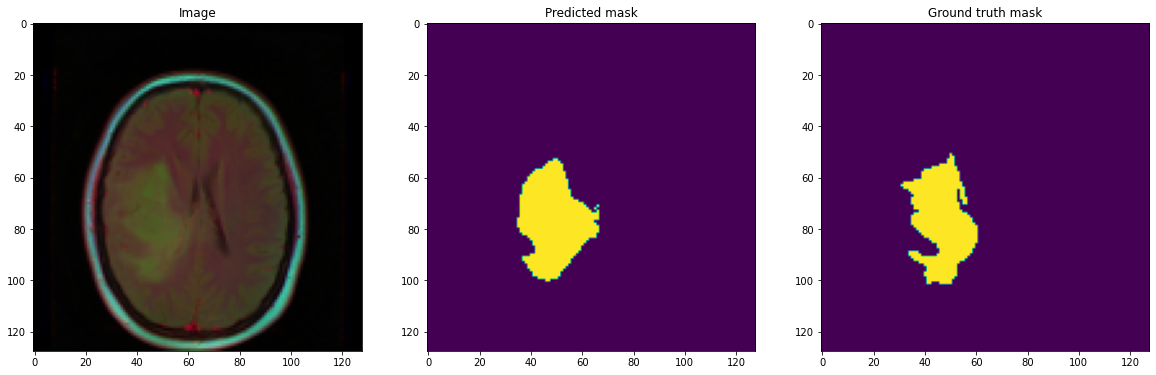

In [91]:
for idx in range(0, 20):
    plot_images(test_images2[idx], predicted_masks2[idx], ground_truth_masks2[idx])
    name="predicted_"+str(idx)+".jpg"
    plt.savefig(name, dpi=600, bbox_inches='tight')

#### Saving results of both models

In [ ]:
for idx in range(20, len(test_images)):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])
    name="predictedmod1/predicted_"+str(idx)+".jpg"
    plt.savefig(name, dpi=600, bbox_inches='tight')
for idx in range(20, len(test_images2)):
    plot_images(test_images2[idx], predicted_masks2[idx], ground_truth_masks2[idx])
    name="predictedmod3/predicted_"+str(idx)+".jpg"
    plt.savefig(name, dpi=600, bbox_inches='tight')

In [134]:
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def loss(y_true, y_pred, beta):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1-beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        logits=y_pred,
        labels=y_true,
        pos_weight=pos_weight,
    )
    return tf.reduce_mean(loss * (1-beta))
def dice_loss(y_true, y_pred):
    numerator = 2. * tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1,2])
    denominator = tf.reduce_sum(tf.add(y_true, y_pred), axis=[1,2])
    x = tf.math.divide_no_nan(numerator, denominator)
    return tf.reduce_mean(1 - x)

def combined(y_true, y_pred,):
    return 0.5*dice_loss(y_true, y_pred) + 0.5*loss(y_true, y_pred, 0.8)

In [135]:
newmodel=tf.keras.models.load_model("model2.hdf5", custom_objects={"combined_loss":combined_loss, "combined":combined, "DiceScore":DiceScore})

In [136]:
newmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_42 (BatchN  (None, 128, 128, 16  64         ['conv2d_45[0][0]']              
 ormalization)                  )                                                           

 concatenate_9 (Concatenate)    (None, 32, 32, 192)  0           ['conv2d_transpose_9[0][0]',     
                                                                  'activation_47[0][0]']          
                                                                                                  
 dropout_21 (Dropout)           (None, 32, 32, 192)  0           ['concatenate_9[0][0]']          
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 64)   110656      ['dropout_21[0][0]']             
                                                                                                  
 batch_normalization_50 (BatchN  (None, 32, 32, 64)  256         ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [137]:
train_loss,train_dice_score=newmodel.evaluate(X_train,y_train)
val_loss, val_dice_score=newmodel.evaluate(X_val,y_val)
test_loss, test_dice_score=newmodel.evaluate(X_test,y_test)

6/6 [==============================] - 5s 872ms/step - loss: 0.1155 - DiceScore: 0.7813


In [138]:
print("Training accuracy of second iteration of second model:")
print(f"Training Loss: {train_loss:.2f} \nTraining Dice Score: {train_dice_score:.2f}")
print(f"Validation Loss: {val_loss:.2f} \nValidation Dice Score: {val_dice_score:.2f}")
print(f"Test Loss: {test_loss:.2f} \nTest Dice Score: {test_dice_score:.2f}")

Training accuracy of second iteration of second model:
Training Loss: 0.08 
Training Dice Score: 0.85
Validation Loss: 0.10 
Validation Dice Score: 0.80
Test Loss: 0.12 
Test Dice Score: 0.78


In [140]:
predicted_masks3, test_images3, ground_truth_masks3 = predict_test_samples(X_test, y_test, newmodel)

6/6 [==============================] - 6s 822ms/step
